In [7]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# Quantum Fourier Transform

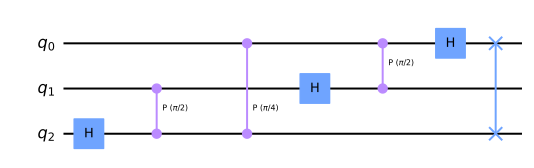

In [8]:
from qiskit.circuit.library import QFT

qft = QFT(3)
qft.draw('mpl')

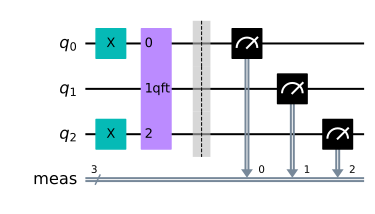

In [9]:
qr = QuantumRegister(3, "q"); 
qc = QuantumCircuit(qr)

# run with input state as bin(5)
qc.x(0); qc.x(2)      
qc.append(qft,qr[:])
qc.measure_all()
qc.draw('mpl')

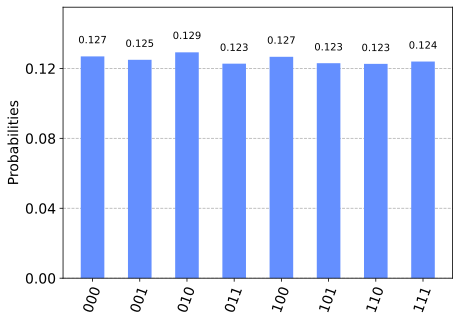

In [10]:
shots = 8196
results = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

$$
\begin{aligned}
\vert j \rangle = & \vert j_1 \ldots j_n \rangle = \vert j_1 \rangle \otimes \ldots \otimes \vert j_n \rangle 
\\
\mapsto & \frac{
\left(\vert0\rangle + e^{2\pi i 0.j_n} \vert1\rangle\right)}{\sqrt{2}}
\otimes
\frac{
\left(\vert0\rangle + e^{2\pi i 0.j_{n-1}j_n} \vert1\rangle\right)}{\sqrt{2}}
\otimes  
\ldots
\otimes
\frac{
\left(\vert0\rangle + e^{2\pi i 0.j_2 \ldots j_n} \vert1\rangle\right)}{\sqrt{2}}
\otimes
\frac{
\left(\vert0\rangle + e^{2\pi i 0.j_1 j_2 \ldots j_n} \vert1\rangle\right)}{\sqrt{2}}
\end{aligned}
$$

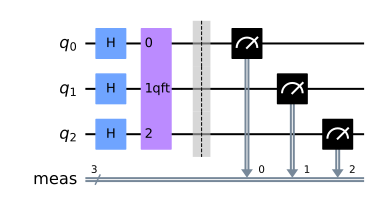

In [11]:
qqr = QuantumRegister(3, "q"); 
qc = QuantumCircuit(qr)

# run with the superposition state
qc.h(qr)      
qc.append(qft,qr[:])
qc.measure_all()
qc.draw('mpl')            

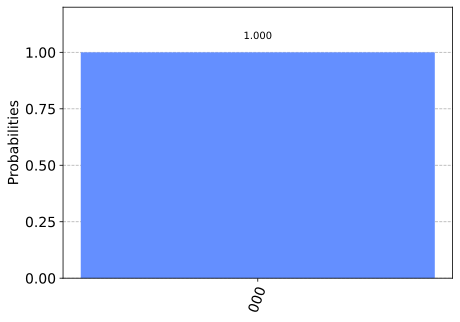

In [12]:
shots = 8196
results = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

### Problem 1 (Quantum Fourier Transform)

Verify that $QFT_{2^n}$ maps $H ^ {\otimes n} \vert 0 \rangle ^ {\otimes n}$ to $\vert 0 \rangle ^ {\otimes n}$ .

# Quantum Phase Estimation

### Phase estimatin with T gate

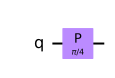

In [13]:
from qiskit.circuit.library import PhaseEstimation

# The unitary is the same T gate. 
unitary = QuantumCircuit(1);    unitary.p(pi/4, 0)
unitary.draw('mpl')

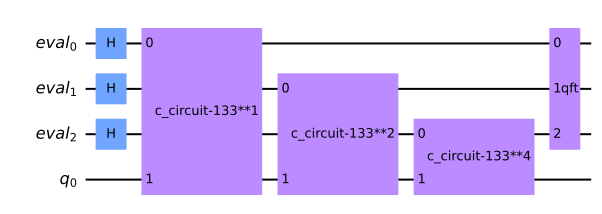

In [14]:
from qiskit.circuit.library import PhaseEstimation

num_eval_qubits=3
pec = PhaseEstimation(num_eval_qubits, unitary, iqft=QFT(num_eval_qubits, inverse=True))
pec.draw('mpl')

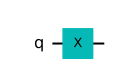

In [15]:
state_preparation = QuantumCircuit(1);  state_preparation.x(0)
state_preparation.draw('mpl')

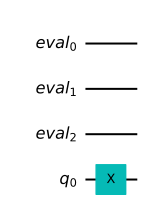

In [16]:
circuit = QuantumCircuit(*pec.qregs)
circuit.compose(state_preparation,
                        list(range(num_eval_qubits, circuit.num_qubits)),
                        inplace=True)
circuit.draw('mpl')

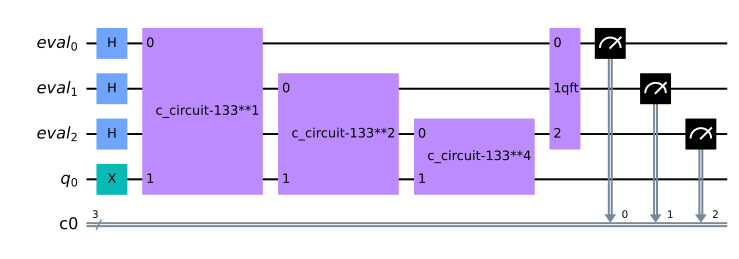

In [17]:
circuit.compose(pec, inplace=True)
cr = ClassicalRegister(num_eval_qubits)
circuit.add_register(cr)
circuit.measure(list(range(num_eval_qubits)), list(range(num_eval_qubits)))
circuit.draw('mpl')

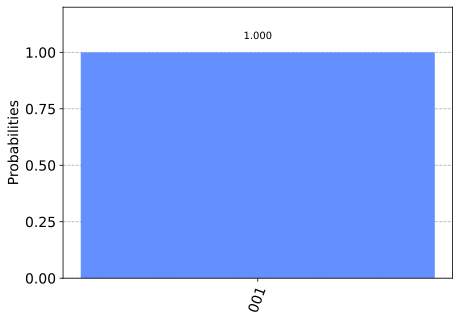

In [18]:
shots = 8192
results = execute(circuit, backend=Aer.get_backend('qasm_simulator'), shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)

In [19]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
nqubits = circuit.num_qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
qbackend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", qbackend)

least busy backend:  ibmq_quito


In [20]:
shots = 8192
job = execute(circuit, backend=qbackend, shots=shots, optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


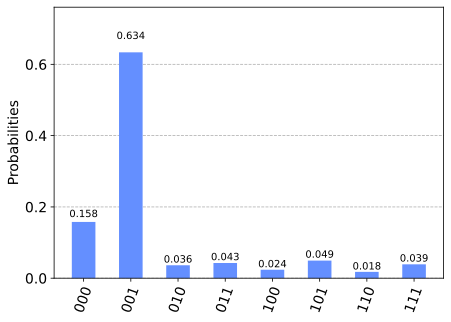

In [21]:
counts = job.result().get_counts()
plot_histogram(counts)

# Quantum Amplitude Estimation

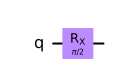

In [68]:
# Simplest Example

theta = 7*pi/8;
unitaryA = QuantumCircuit(1);  
unitaryA.rx(np.pi/2,0);    #  cos theta |0> + sin theta |1> 
unitaryA.draw('mpl')

In [69]:
Statevector(unitaryA)

Statevector([0.70710678+0.j        , 0.        -0.70710678j],
            dims=(2,))


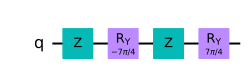

In [70]:
amplifier = QuantumCircuit(1);  
#  A (2|0><0|-I) A_\dagger O
amplifier.z(0)             # oracle
amplifier.ry(-2*theta, 0)   # A_\dagger
amplifier.z(0)             # 2|0><0|-I
amplifier.ry(2*theta, 0)  # A
amplifier.draw('mpl')

In [71]:
from qiskit.quantum_info import Statevector
Statevector(amplifier)

Statevector([ 0.70710678+0.j, -0.70710678+0.j],
            dims=(2,))


### Try amplitude estimation with phase estimation!

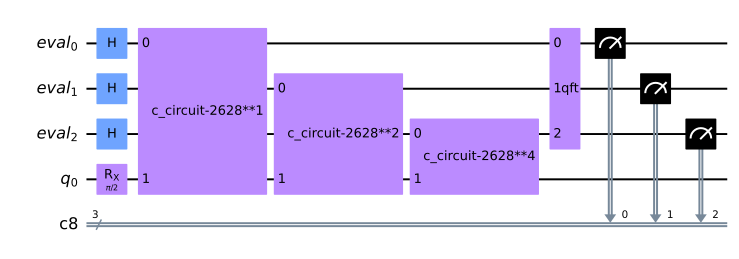

In [72]:
num_eval_qubits=3
pec = PhaseEstimation(num_eval_qubits, amplifier, iqft=QFT(num_eval_qubits, inverse=True))

# Compose the phase estimation circuite
circuit = QuantumCircuit(*pec.qregs)
circuit.compose(unitaryA,
                        list(range(num_eval_qubits, circuit.num_qubits)),
                        inplace=True)
circuit.compose(pec, inplace=True)
# add measurements
cr = ClassicalRegister(num_eval_qubits)
circuit.add_register(cr)
circuit.measure(list(range(num_eval_qubits)), list(range(num_eval_qubits)))
circuit.draw('mpl')

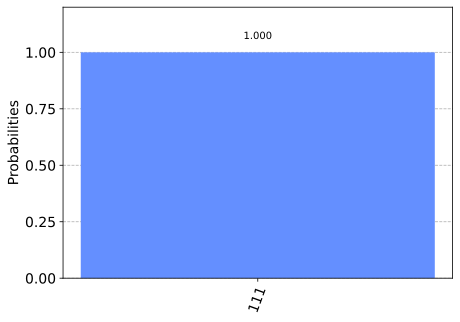

In [73]:
shots = 8192
results = execute(circuit, backend=Aer.get_backend('qasm_simulator'), shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)

### Problem 2 (Quantum Amplitude Estimation)

Show a normalized eigenvector for each of the egenvalues $e^{\pm 2i \theta}$ of the $2 \theta$ rotation matrix. Then explain why the measurement results for $\theta / \pi$  and $1 - (\theta / \pi)$ are equally observed in the amplitude estimation with phase estimation as in our qiskit demonstration. 

In [26]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.3', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}